# Pre Loading Libraries

In [1]:
from keras.preprocessing.text import Tokenizer
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from collections import Counter
from pathlib import Path
import os
import numpy as np
import re
import string
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import wordnet
import unicodedata
import html
stop_words = stopwords.words('english')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

# Data Loading & Exploration

In [67]:
df = pd.read_csv('train.csv')
display(df.head(100))
display(df.info())

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
95,137,accident,Charlotte,9 Mile backup on I-77 South...accident blockin...,1
96,138,accident,"Baton Rouge, LA",Has an accident changed your life? We will hel...,0
97,139,accident,"Hagerstown, MD",#BREAKING: there was a deadly motorcycle car a...,1
98,141,accident,"Gloucestershire , UK",@flowri were you marinading it or was it an ac...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


None

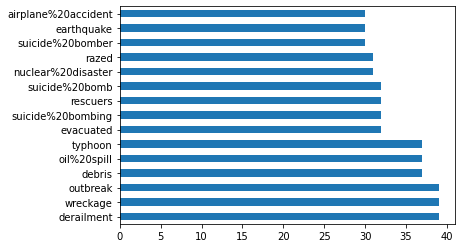

In [68]:
import seaborn as sns

df_dis = df[df['target']==1]
df_dis['keyword'].value_counts()[:15].plot(kind='barh')

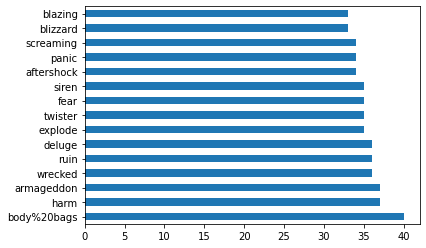

In [69]:
df_non_dis = df[df['target']==0]
df_non_dis['keyword'].value_counts()[:15].plot(kind='barh')

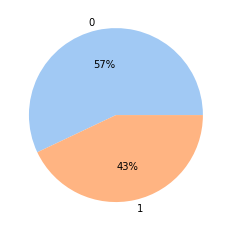

In [70]:
import seaborn as sns

#define data
data = [4342, 3271]
labels = ['0', '1']

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()


In [71]:
df = df.drop(['id', 'keyword','location'], axis = 1)
df.head()


,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


# Data Cleaning

**Make Characters to Lower Case**

In [72]:
df["CleanText"] = df["text"].apply(lambda x: x.lower())
df.head()

,text,target,CleanText
0,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada
2,All residents asked to 'shelter in place' are ...,1,all residents asked to 'shelter in place' are ...
3,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or..."
4,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby #alaska as ...


**Remove unnecessary text: URL,HTML,Emojis, punctuation**

In [73]:
#remove URL

df["CleanText"] = df["CleanText"].apply(lambda x: re.sub(r"https?://\S+|www\.\S+", "",x))


In [74]:
def removeHTML(text):
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)

df["CleanText"] = df["CleanText"].apply(lambda x: removeHTML(x))


In [75]:
def removeEmojis(text):
    emoji_pattern = re.compile("["
                       u"\U0001F600-\U0001F64F"  # emoticons
                       u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                       u"\U0001F680-\U0001F6FF"  # transport & map symbols
                       u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                       u"\U00002702-\U000027B0"
                       u"\U000024C2-\U0001F251"
                       u"\U0001f926-\U0001f937"
                       u"\u200d"
                       u"\u2640-\u2642" 
                       "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df["CleanText"] = df["CleanText"].apply(lambda x: removeEmojis(x))


In [76]:
def RemovePunctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [77]:
df["CleanText"] = df["CleanText"].apply(lambda x: RemovePunctuation(x))


In [78]:
def RemoveASCII(text):
  return re.sub(r'[^\x00-\x7f]', "", text)

df["CleanText"] = df["CleanText"].apply(lambda x: RemoveASCII(x))

In [79]:
df.head()


,text,target,CleanText
0,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...
4,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...


#Data Preprocessing Part1 ([NLTK](https://www.nltk.org/index.html)) 

**Tokenizer**

In [80]:
df['TokenizedText'] = df['CleanText'].apply(nltk.word_tokenize)

In [81]:
display(df.head())

,text,target,CleanText,TokenizedText
0,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth..."
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]"
2,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place..."
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation..."
4,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala..."


**Remove Stopwords**

In [82]:
stop = set(stopwords.words('english'))
df['RemoveStopWords'] = df['TokenizedText'].apply(lambda x: [word for word in x if word not in stop])
df.head()


,text,target,CleanText,TokenizedText,RemoveStopWords
0,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv..."
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o..."
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation..."
4,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi..."


**PorterStemmer**

What is PorterStemmer in NLP?
Stemming is the process of reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words known as a lemma. Stemming is important in natural language understanding (NLU) and natural language processing (NLP).

In [83]:
def doPorterStemmer(text):
    stemmer = nltk.PorterStemmer()
    stems = [stemmer.stem(i) for i in text]
    return stems

df['PorterStemmer'] = df['RemoveStopWords'].apply(lambda x: doPorterStemmer(x))
df.head()

,text,target,CleanText,TokenizedText,RemoveStopWords,PorterStemmer
0,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[deed, reason, earthquak, may, allah, forgiv, us]"
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, rong, sask, canada]"
2,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[resid, ask, shelter, place, notifi, offic, ev..."
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, peopl, receiv, wildfir, evacu, order, ..."
4,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[got, sent, photo, rubi, alaska, smoke, wildfi..."


**WordNetLemmatizer**

In [84]:
def doLemmatizeWord(text):
    lemmatizer = WordNetLemmatizer()
    lemma = [lemmatizer.lemmatize(word) for word in text]
    return lemma

df['LemmatizedText'] = df['RemoveStopWords'].apply(lambda x: doLemmatizeWord(x))
df.head()


,text,target,CleanText,TokenizedText,RemoveStopWords,PorterStemmer,LemmatizedText
0,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[deed, reason, earthquak, may, allah, forgiv, us]","[deed, reason, earthquake, may, allah, forgive..."
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, rong, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[resid, ask, shelter, place, notifi, offic, ev...","[resident, asked, shelter, place, notified, of..."
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, peopl, receiv, wildfir, evacu, order, ...","[13000, people, receive, wildfire, evacuation,..."
4,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[got, sent, photo, rubi, alaska, smoke, wildfi...","[got, sent, photo, ruby, alaska, smoke, wildfi..."


In [85]:
df['FINAL']=df['LemmatizedText'].apply(lambda x: ''.join(i+' ' for i in x))
df.head()

,text,target,CleanText,TokenizedText,RemoveStopWords,PorterStemmer,LemmatizedText,FINAL
0,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[deed, reason, earthquak, may, allah, forgiv, us]","[deed, reason, earthquake, may, allah, forgive...",deed reason earthquake may allah forgive u
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, rong, sask, canada]","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[resid, ask, shelter, place, notifi, offic, ev...","[resident, asked, shelter, place, notified, of...",resident asked shelter place notified officer ...
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, peopl, receiv, wildfir, evacu, order, ...","[13000, people, receive, wildfire, evacuation,...",13000 people receive wildfire evacuation order...
4,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[got, sent, photo, rubi, alaska, smoke, wildfi...","[got, sent, photo, ruby, alaska, smoke, wildfi...",got sent photo ruby alaska smoke wildfire pour...


In [86]:
df.to_csv("normalized_dataset.csv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


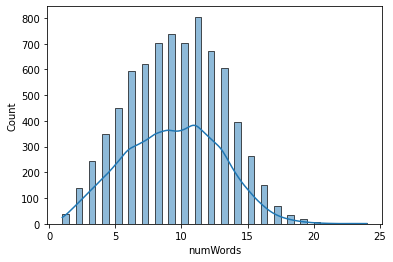

In [87]:
df['LemmatizedText']


df['numWords']= 0

for ind in df.index:
     #print(len(df['LemmatizedText'][ind]))
     df['numWords'][ind] = len(df['LemmatizedText'][ind])

df.head()

sns.histplot(data=df, x="numWords", kde=True)


## Visualization with WordCloud (Target-1 Target-0)

In [88]:
!pip install git+https://git@github.com/kavgan/word_cloud.git

  Cloning https://****@github.com/kavgan/word_cloud.git to /tmp/pip-req-build-clr2jjj1
  Running command git clone -q 'https://****@github.com/kavgan/word_cloud.git' /tmp/pip-req-build-clr2jjj1
  Created wheel for word-cloud: filename=word_cloud-0.0.0-py3-none-any.whl size=5896 sha256=ee5d51eb01dbbd3727fca2a06726154f801b57be814a723e197113cf85fdd9c7
  Stored in directory: /tmp/pip-ephem-wheel-cache-hfwwtlae/wheels/31/4e/42/acc6e2273058cf74bac4046fcc43d99a1016e6967c001d1fcf
Successfully built word-cloud


In [89]:
df_disaster = df[df['target']==1]
df_nodisater = df[df['target']==0]

In [90]:
ENGLISH_STOP_WORDS = frozenset([
    "a", "about", "above", "across", "after", "afterwards", "again", "against",
    "all", "almost", "alone", "along", "already", "also", "although", "always",
    "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
    "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are",
    "around", "as", "at", "back", "be", "became", "because", "become",
    "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
    "below", "beside", "besides", "between", "beyond", "bill", "both",
    "bottom", "but", "by", "call", "can", "cannot", "cant", "co", "con",
    "could", "couldnt", "cry", "de", "describe", "detail", "do", "done",
    "down", "due", "during", "each", "eg", "eight", "either", "eleven", "else",
    "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
    "everything", "everywhere", "except", "few", "fifteen", "fifty", "fill",
    "find", "fire", "first", "five", "for", "former", "formerly", "forty",
    "found", "four", "from", "front", "full", "further", "get", "give", "go",
    "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter",
    "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his",
    "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed",
    "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter",
    "latterly", "least", "less", "ltd", "made", "many", "may", "me",
    "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly",
    "move", "much", "must", "my", "myself", "name", "namely", "neither",
    "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone",
    "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on",
    "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our",
    "ours", "ourselves", "out", "over", "own", "part", "per", "perhaps",
    "please", "put", "rather", "re", "same", "see", "seem", "seemed",
    "seeming", "seems", "serious", "several", "she", "should", "show", "side",
    "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone",
    "something", "sometime", "sometimes", "somewhere", "still", "such",
    "system", "take", "ten", "than", "that", "the", "their", "them",
    "themselves", "then", "thence", "there", "thereafter", "thereby",
    "therefore", "therein", "thereupon", "these", "they", "thick", "thin",
    "third", "this", "those", "though", "three", "through", "throughout",
    "thru", "thus", "to", "together", "too", "top", "toward", "towards",
    "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us",
    "very", "via", "was", "we", "well", "were", "what", "whatever", "when",
    "whence", "whenever", "where", "whereafter", "whereas", "whereby",
    "wherein", "whereupon", "wherever", "whether", "which", "while", "whither",
    "who", "whoever", "whole", "whom", "whose", "why", "will", "with",
    "within", "without", "would", "yet", "said","you", "your", "yours", "yourself",
    "yourselves"])

In [91]:
from word_cloud.word_cloud_generator import WordCloud
from IPython.core.display import HTML

texts= df_disaster['FINAL']
wc=WordCloud(use_tfidf=False,stopwords=ENGLISH_STOP_WORDS)

embed_code=wc.get_embed_code(text=texts,random_color=False,topn=50)
HTML(embed_code)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [92]:
texts= df_nodisater['FINAL']
wc=WordCloud(use_tfidf=False,stopwords=ENGLISH_STOP_WORDS)

embed_code=wc.get_embed_code(text=texts,random_color=False,topn=50)
HTML(embed_code)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Data PreProcessing Part2 to transform numerical feature vector


**We will make three different numerical datasets**

**Bag Of Words using CounterVector**

In [93]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
cv_df = vectorizer.fit_transform(df['FINAL'])

vectorizer.get_feature_names_out()
print(cv_df.shape)

(7613, 16270)


**Visualization**


In [95]:
#cv_arr = cv_df.toarray()
#cv_arr_df = pd.DataFrame(data=cv_arr,columns = vectorizer.get_feature_names())
#desc = cv_arr_df.describe()
 
#dict(sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1],reverse=True))
'''
dis_countvectorizer = CountVectorizer()
cv_disaster = dis_countvectorizer.fit_transform(df_disaster['FINAL'])

nodis_countvectorizer = CountVectorizer()
cv_nodisaster = nodis_countvectorizer.fit_transform(df_nodisater['FINAL'])

sorted_cv_dis = dict(sorted(dis_countvectorizer.vocabulary_.items(), key=lambda item: item[1],reverse=True))
sorted_cv_nodis = dict(sorted(nodis_countvectorizer.vocabulary_.items(), key=lambda item: item[1],reverse=True))
'''
#print(sorted_cv_dis)
#print(sorted_cv_nodis)

#print(dis_countvectorizer.vocabulary_.keys())

"\ndis_countvectorizer = CountVectorizer()\ncv_disaster = dis_countvectorizer.fit_transform(df_disaster['FINAL'])\n\nnodis_countvectorizer = CountVectorizer()\ncv_nodisaster = nodis_countvectorizer.fit_transform(df_nodisater['FINAL'])\n\nsorted_cv_dis = dict(sorted(dis_countvectorizer.vocabulary_.items(), key=lambda item: item[1],reverse=True))\nsorted_cv_nodis = dict(sorted(nodis_countvectorizer.vocabulary_.items(), key=lambda item: item[1],reverse=True))\n"

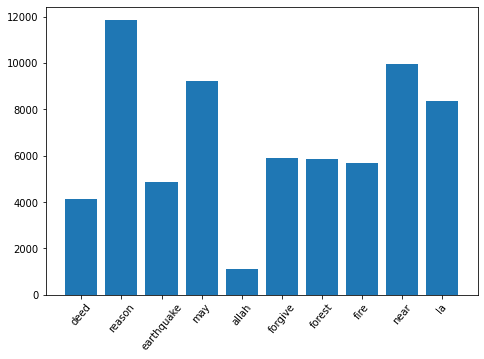

In [94]:
cv_key_list = list(vectorizer.vocabulary_.keys())
cv_values_list = list(vectorizer.vocabulary_.values())
#print(cv_key_list)
#print(cv_values_list)

import matplotlib.pyplot as plt
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ax.bar(cv_key_list[:10], cv_values_list[:10])
plt.xticks(rotation=50)
plt.show()

**TF-IDF**


In [96]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfvectorizer = TfidfVectorizer(ngram_range = (1,2))
tfidf_df = tfvectorizer.fit_transform(df['FINAL'])
print(tfidf_df.shape)

(7613, 63245)


 **visualization**

In [97]:
'''dis_tdidfvectorizer = CountVectorizer()
tdidf_disaster = dis_tdidfvectorizer.fit_transform(df_disaster['FINAL'])

nodis_tdidfvectorizer = CountVectorizer()
tdidf_nodisaster = nodis_tdidfvectorizer.fit_transform(df_nodisater['FINAL'])

#print(dis_tdidfvectorizer.vocabulary_)
#print(nodis_tdidfvectorizer.vocabulary_)

sorted_tdidf_dis = dict(sorted(dis_tdidfvectorizer.vocabulary_.items(), key=lambda item: item[1],reverse=True))
sorted_tdidf_nodis = dict(sorted(nodis_tdidfvectorizer.vocabulary_.items(), key=lambda item: item[1],reverse=True))

#print(sorted_tdidf_dis)
#print(sorted_tdidf_nodis)'''

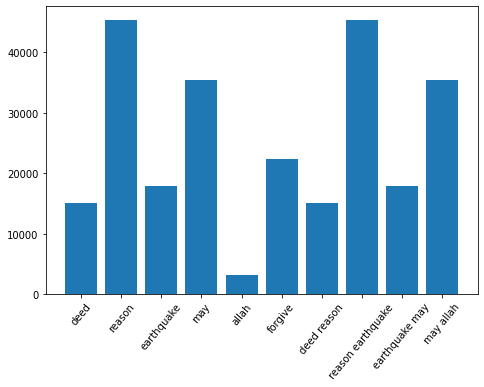

In [98]:
tfidf_key_list = list(tfvectorizer.vocabulary_.keys())
tfidf_values_list = list(tfvectorizer.vocabulary_.values())
#print(tfidf_key_list)
#print(tfidf_values_list)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(tfidf_key_list[:10], tfidf_values_list[:10])
plt.xticks(rotation=50)
plt.show()

**Word2Vec**

In [99]:
from gensim.models import Word2Vec, KeyedVectors
import nltk
import multiprocessing

In [100]:
sentences = df['FINAL'].values
sentences = [nltk.word_tokenize(title) for title in sentences]
#print(sentences)

In [101]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer


w2v_model = Word2Vec(min_count=1,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)


In [102]:
w2v_model.build_vocab(sentences, progress_per=10000)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(1441465, 2133030)

In [103]:
w2v_model.wv.similarity("fire", 'wildfire')


0.9791522

In [104]:
w2v_model.wv.most_similar(positive=["disaster"])


[('declares', 0.997846782207489),
 ('sign', 0.9974989891052246),
 ('marians', 0.9947875738143921),
 ('declaration', 0.9942320585250854),
 ('obama', 0.9941347241401672),
 ('saipan', 0.9925720691680908),
 ('northern', 0.9884618520736694),
 ('typhoondevastated', 0.9879880547523499),
 ('abcnews', 0.893616795539856),
 ('losdelsonido', 0.8928853273391724)]

In [105]:
w2v_model.wv.most_similar(positive=["evacuation"])


[('faan', 0.9996840953826904),
 ('order', 0.9995522499084473),
 ('ultimatum', 0.9993404746055603),
 ('lifted', 0.9993184208869934),
 ('floated', 0.9992814064025879),
 ('town', 0.999279260635376),
 ('noted', 0.9992765188217163),
 ('jet', 0.999265193939209),
 ('th', 0.9992451667785645),
 ('cabin', 0.9992271661758423)]

In [106]:
w2v_model.wv.most_similar(positive=["injury"])


[('thought', 0.9998135566711426),
 ('client', 0.999805212020874),
 ('kid', 0.9998036026954651),
 ('usually', 0.9998034834861755),
 ('seeing', 0.9998022317886353),
 ('marvel', 0.9998008012771606),
 ('tough', 0.9998008012771606),
 ('meeting', 0.9998006820678711),
 ('throwing', 0.9997994899749756),
 ('detail', 0.9997949600219727)]

In [107]:
words = list(w2v_model.wv.vocab)
#words

In [108]:
w2v_df = []
for sent in sentences:
    vw = np.zeros(300) 
    #one sentence has many words
    for word in sent:
        vw += w2v_model[word]
    #average
    vw = vw/len(sent)
    w2v_df.append(np.array(vw))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [109]:
print(len(w2v_df))
#print(w2v_model['earthquake'])

7613


## Word2Vec with Visualization

In [110]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def word2vec_scatterplot(model, word, list_names):

    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality with PCA
    reduc = PCA(n_components=21).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


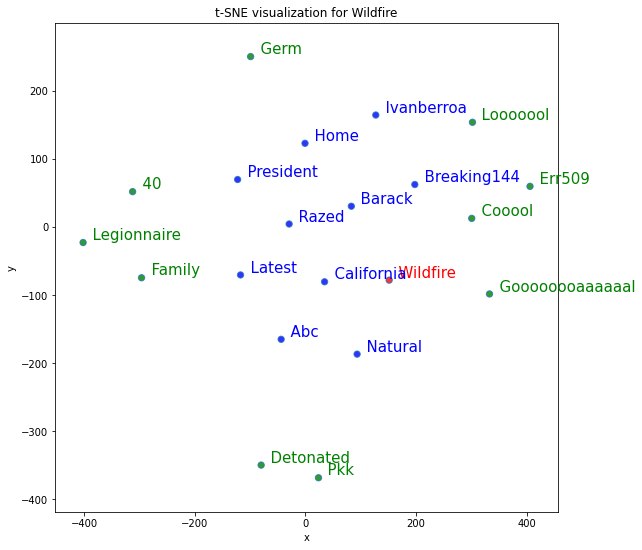

In [111]:
word2vec_scatterplot(w2v_model, 'wildfire', [i[0] for i in w2v_model.wv.most_similar(negative=["wildfire"])])


# Reduce Dimension PCA 

In [ ]:
from sklearn.preprocessing import StandardScaler
'''ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.'''
from sklearn.decomposition import PCA
'''TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.'''
from sklearn.decomposition import TruncatedSVD
'''
trans_cv_df = StandardScaler(with_mean=False).fit_transform(cv_df)

#reduce dimention half
svd = TruncatedSVD(n_components=100)
svd_trans_cv_df = svd.fit_transform(trans_cv_df)

print(svd_trans_cv_df.shape)
'''

'\ntrans_cv_df = StandardScaler(with_mean=False).fit_transform(cv_df)\n\n#reduce dimention half\nsvd = TruncatedSVD(n_components=100)\nsvd_trans_cv_df = svd.fit_transform(trans_cv_df)\n\nprint(svd_trans_cv_df.shape)\n'

In [ ]:

'''trans_tfidf_df = StandardScaler(with_mean=False).fit_transform(tfidf_df)
#reduce dimention half
svd = TruncatedSVD(n_components=100)
svd_trans_tfidf_df = svd.fit_transform(trans_tfidf_df)

print(svd_trans_tfidf_df.shape)'''


'trans_tfidf_df = StandardScaler(with_mean=False).fit_transform(tfidf_df)\n#reduce dimention half\nsvd = TruncatedSVD(n_components=100)\nsvd_trans_tfidf_df = svd.fit_transform(trans_tfidf_df)\n\nprint(svd_trans_tfidf_df.shape)'

(7613, 100)


,com1,com2
0,-0.527309,-0.392581
1,-1.352886,-0.166789
2,-0.310847,0.565151
3,-1.369246,4.587354
4,-1.709514,1.010529


,com1,com2,target
0,-0.527309,-0.392581,1
1,-1.352886,-0.166789,1
2,-0.310847,0.565151,1
3,-1.369246,4.587354,1
4,-1.709514,1.010529,1


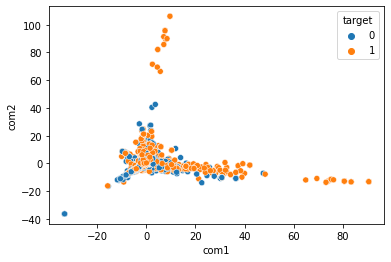

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

trans_w2v_df = StandardScaler().fit_transform(w2v_df)

#reduce dimention half
pca = PCA(n_components=100)
pca_trans_w2v_df = pca.fit_transform(trans_w2v_df)

print(pca_trans_w2v_df.shape) 

df_pca_visual = pd.DataFrame({'com1': pca_trans_w2v_df[:,1], 'com2': pca_trans_w2v_df[:,2]})
display(df_pca_visual.head())

df_pca_visual['target'] = df['target']
display(df_pca_visual.head())

sns.scatterplot(data=df_pca_visual, x="com1", y="com2", hue="target")

In [ ]:
'''
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

trans_w2v_df = StandardScaler().fit_transform(w2v_df)

# apply Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis(n_components=1)
lda_w2v_df = lda.fit_transform(trans_w2v_df, df['target'])
print(lda_w2v_df.shape) 


lda_w2v_df_visual = pd.DataFrame({'lda_com': lda_w2v_df[:,0]})
display(lda_w2v_df_visual.head())

lda_w2v_df_visual['target'] = df['target']
display(lda_w2v_df_visual.head())


import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.stripplot(x="lda_com" ,y="target" , data=lda_w2v_df_visual)'''
  

(7613, 2)


,com1,com2
0,-0.783916,-0.527309
1,1.651099,-1.352886
2,0.027701,-0.310847
3,-0.760318,-1.369246
4,-1.076444,-1.709514


,com1,com2,target
0,-0.783916,-0.527309,1
1,1.651099,-1.352886,1
2,0.027701,-0.310847,1
3,-0.760318,-1.369246,1
4,-1.076444,-1.709514,1


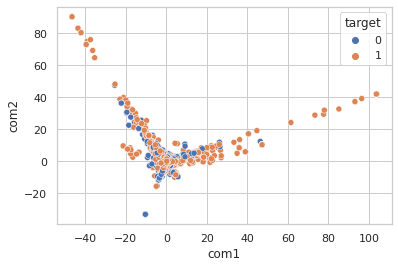

In [ ]:
# This is for visualization code
from sklearn.decomposition import PCA

pca_visual = PCA(n_components=2)
df_visual = pca_visual.fit_transform(trans_w2v_df)
print(df_visual.shape) 

df_pca_visual = pd.DataFrame(df_visual, columns=['com1', 'com2'])
display(df_pca_visual.head())

df_pca_visual['target'] = df['target']
display(df_pca_visual.head())

sns.scatterplot(data=df_pca_visual, x="com1", y="com2", hue="target")
